In [47]:
import numpy as np
import scipy.stats as s
import configparser
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime

from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/marat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
def plot_beta(bot, human, rnd, title='', legend=True):
    neg, pos = bot
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'bot {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'r-', lw=5, alpha=0.6, label=label)

    neg, pos = human
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'human {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'g-', lw=5, alpha=0.6, label=label)
       
    neg, pos = rnd
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'random {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'b-', lw=5, alpha=0.6, label=label)
    
    
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    plt.title('{} (Fisher test z={:.3f}, pvalue={:.4f})'.format(title, *ztest))
    if legend:
        plt.legend()
    plt.xlim(0, 1)
    
def compare(data, eps=1e-2):
    res = {}
    for g, d in data.groupby(['operator', 'is_meaningful']):
        x = d['question'].apply(lambda x: len(word_tokenize(x)))
        res[g] = (x <= 15).sum()
#         res[g] = len(d)

    bot = [res.get(('bot', 0), eps), res.get(('bot', 1), eps)]
    human = [res.get(('human', 0), eps), res.get(('human', 1), eps)]
    rnd = [res.get(('random', 0), eps), res.get(('random', 1), eps)]

    chi = s.chisquare(bot, f_exp=human)
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    
    return [chi.pvalue, ztest], [bot, human, rnd], human[1] / (human[0] + human[1]), bot[1] / (bot[1] + bot[0]), rnd[1] / (rnd[1] + rnd[0])

In [39]:
def has_word(word):
    def f(x):
        return word in x.lower()
    return f


In [40]:
data = pd.read_csv('target/sber2.tsv', sep='\t', na_values='None')

has_thanks = data['question'].apply(has_word('спасибо'))
has_hello = data['question'].apply(has_word('здравствуйте'))

data = data[(~has_thanks) & (~has_hello)]

Index(['chat_id', 'user', 'question_id', 'operator', 'question', 'answer',
       'time_asked', 'time_answered', 'is_meaningful', 'discriminator_score'],
      dtype='object')
overall 1116 ([7.1323107235904114e-20, (-4.9145847623274053, 8.8970826747936099e-07)], [[89, 101], [84, 243], [178, 80]], 0.74311926605504586, 0.53157894736842104, 0.31007751937984496)


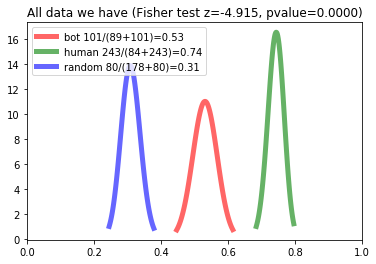

In [42]:
print(data.columns)

c = compare(data)
print('overall', len(data), c)

_, [bot, human, rnd], *_2 = c
plot_beta(bot, human, rnd, title='All data we have')
plt.show()

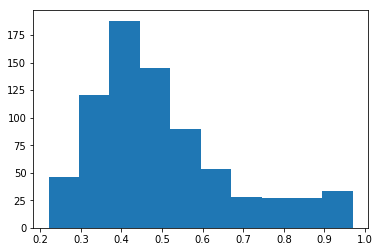

In [43]:
v = data['discriminator_score'].values
plt.hist(v[~np.isnan(v)])
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


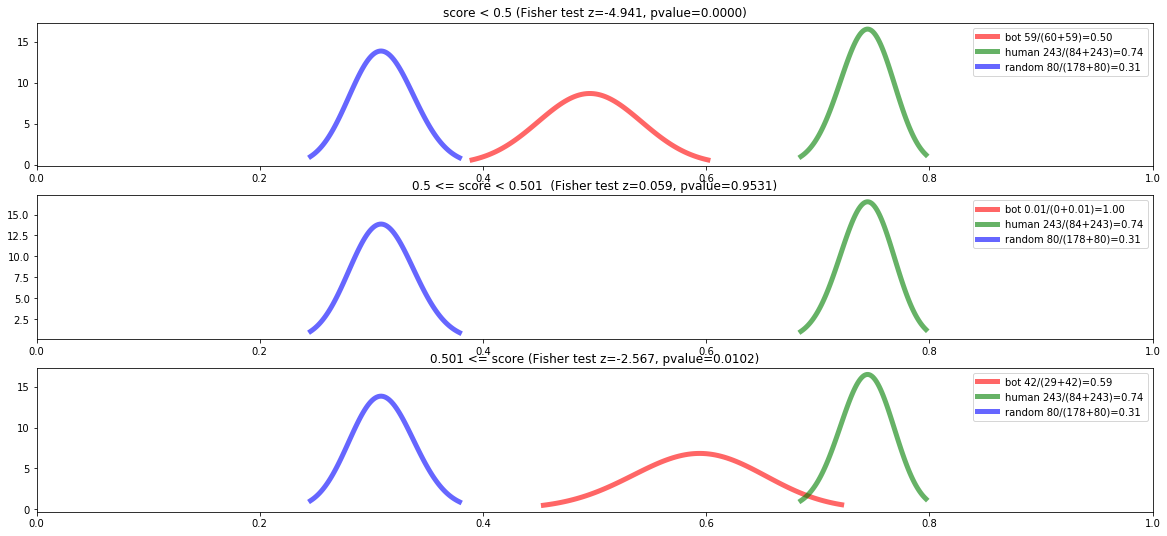

In [44]:
t1 = 0.5
t2 = 0.501
data['score_class'] = np.digitize(data['discriminator_score'], [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'score < {t1}'),
                              (1, f'{t1} <= score < {t2} '),
                              (2, f'{t2} <= score')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['operator'] != 'bot') | ((data['operator'] == 'bot') & (data['score_class'] == class_id))
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

In [18]:
data.columns

Index(['chat_id', 'user', 'question_id', 'operator', 'question', 'answer',
       'time_asked', 'time_answered', 'is_meaningful', 'discriminator_score',
       'score_class'],
      dtype='object')

discriminator score >= 0.000 pval=0.0000 for 288 samples
discriminator score >= 0.059 pval=0.0000 for 288 samples
discriminator score >= 0.118 pval=0.0000 for 288 samples
discriminator score >= 0.176 pval=0.0000 for 288 samples
discriminator score >= 0.235 pval=0.0000 for 285 samples
discriminator score >= 0.294 pval=0.0000 for 265 samples
discriminator score >= 0.353 pval=0.0000 for 216 samples
discriminator score >= 0.412 pval=0.0007 for 153 samples
discriminator score >= 0.471 pval=0.0200 for 106 samples
discriminator score >= 0.529 pval=0.0701 for 55 samples
discriminator score >= 0.588 pval=0.7699 for 28 samples
discriminator score >= 0.647 pval=0.5530 for 18 samples
discriminator score >= 0.706 pval=0.6716 for 11 samples
discriminator score >= 0.765 pval=0.9531 for 1 samples


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


discriminator score >= 0.824 pval=0.9373 for 0 samples
discriminator score >= 0.882 pval=0.9373 for 0 samples
discriminator score >= 0.941 pval=0.9373 for 0 samples
discriminator score >= 1.000 pval=0.9373 for 0 samples


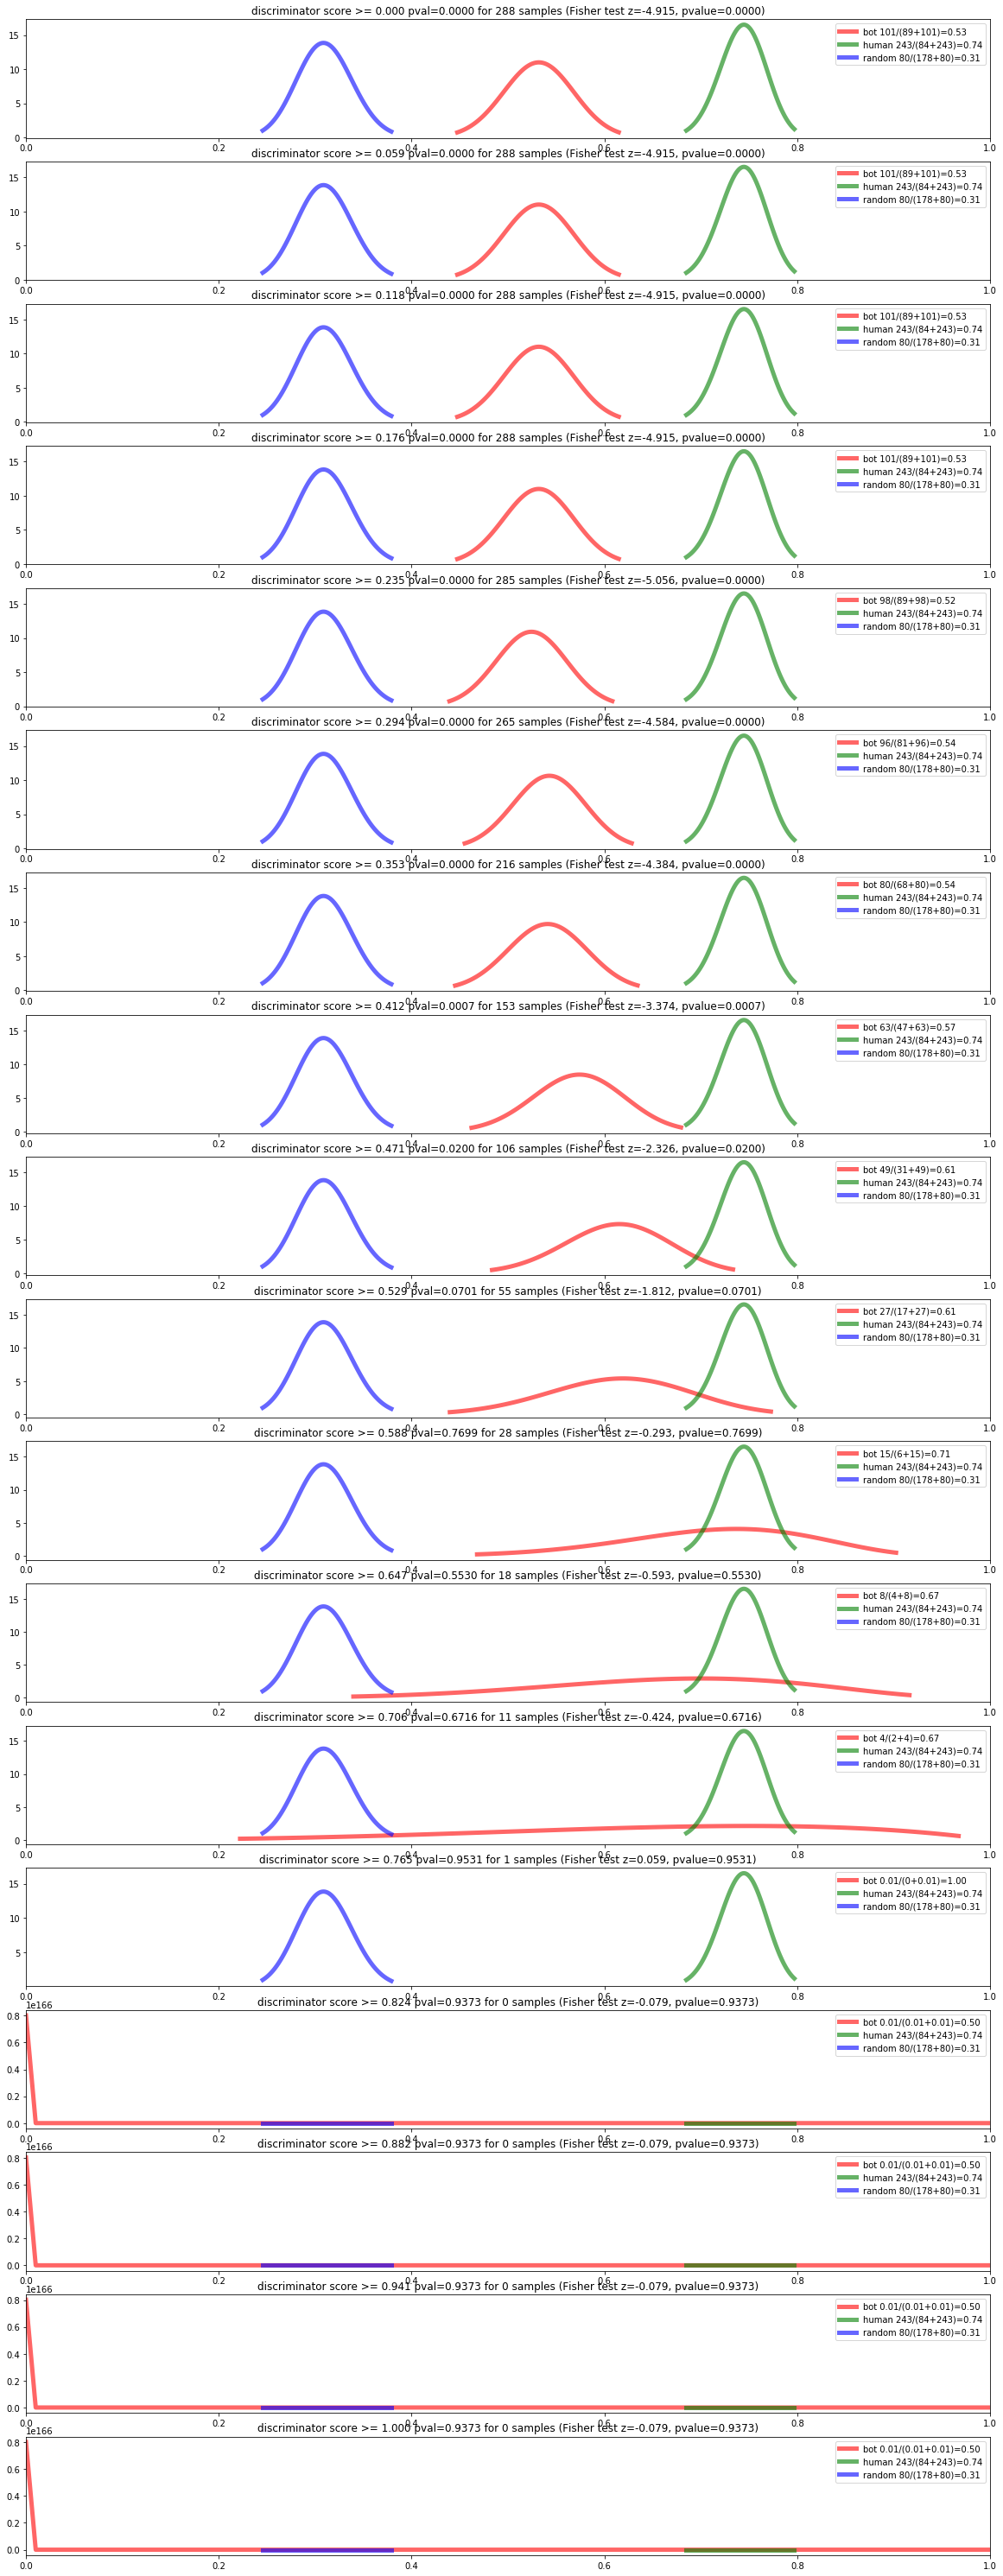

In [45]:
thresholds = np.linspace(0, 1, 18)
plt.figure(figsize=(20, len(thresholds)*3))
for i, threshold in enumerate(thresholds):
    k_nice_bot_answers = (data['operator'] == 'bot') & (data['discriminator_score'] > threshold)
    k_with_rest = (data['operator'] != 'bot') | k_nice_bot_answers
    [chi, (stat, pval)], operators, *__ = compare(data[k_with_rest])
    plt.subplot(len(thresholds), 1, i+1)
    title = 'discriminator score >= {0:.3f} pval={1:.4f} for {2} samples'.format(threshold, pval, k_nice_bot_answers.sum())
    plot_beta(*operators, title=title)

    print(title)
plt.show()

In [46]:
for i, row in data[(data['operator']=='bot') & (data['discriminator_score'] > 0.5)].iterrows():
    print('>>>', row['question'])
    print(row['answer'])
    print()

>>> После того как доставлен все ждем когда будет исполнен
 У Вас платеж будет исполнен в течение 10 дней . Возможно , у Вас остались еще какие-либо вопросы ко мне ?

>>> ясно
 Для создания заявки , пожалуйста , перейдите в раздел « Продукты и услуги » - « Корпоративные карты » . Во вкладке « Карты » выберите , пожалуйста , Вашу карту одним кликом и нажмите на кнопку « Изменить лимиты » . Уточнить допустимые лимиты Вы можете по ссылке « Показать лимиты карт » . В первой строке Вы можете указать максимально допустимые лимиты , а также те значения , которые необходимы Вам . Значения в данной строке являются суммой всех возможных лимитов по всем картам . В следующей строке необходимо указать лимиты для определенной карты . Чтобы установить лимиты для другой карты , следует нажать на ссылку « Добавить карту » . После заполнения заявления нажмите , пожалуйста , на кнопку « Создать » , подпишите документ и отправьте в Банк на обработку . Остались ли у Вас еще вопросы ?

>>> Вопросов больше н